In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import pandas as pd 
import numpy as np
import pmdarima as pm 
import matplotlib.pyplot as plt 

plt.style.use('bmh')

In [3]:
sun_data = pd.read_csv('../ts_data/sunspot.csv', header=None)
sun_data

,0
0,58.0
1,62.6
2,70.0
3,55.7
4,85.0
...,...
2815,71.8
2816,50.3
2817,55.8
2818,33.3


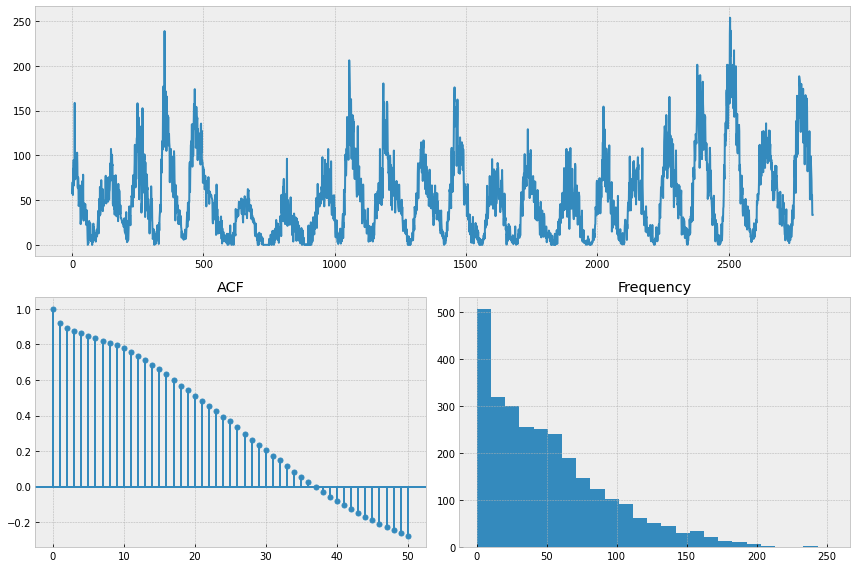

In [4]:
pm.tsdisplay(sun_data, figsize=(12,8))

## Box-Cox transformation

In [5]:
boxcox = pm.preprocessing.BoxCoxEndogTransformer(lmbda2=1e-6)
data_boxcox, _ = boxcox.fit_transform(sun_data)

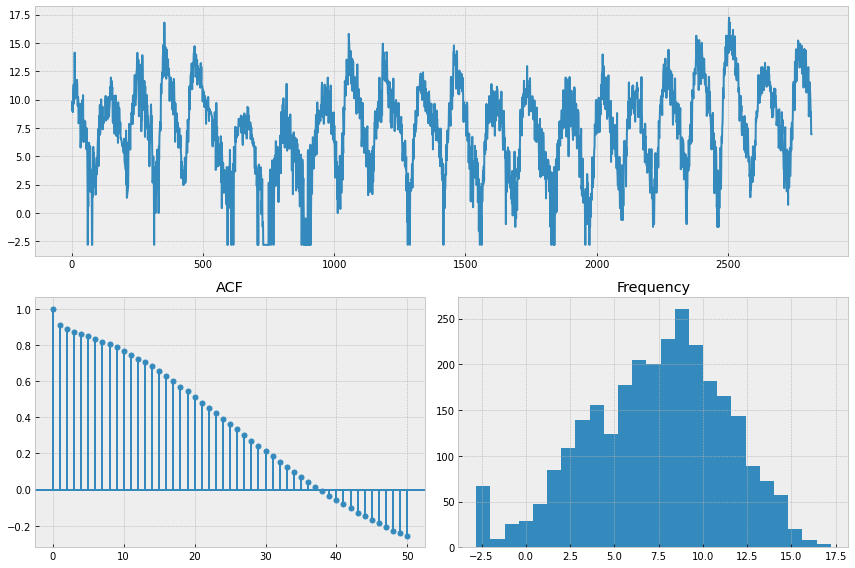

In [6]:
pm.tsdisplay(data_boxcox, figsize=(12,8))

## Log transformation

In [7]:
log_tf = pm.preprocessing.LogEndogTransformer(lmbda=1e-6)
y_log, _ = log_tf.fit_transform(sun_data)

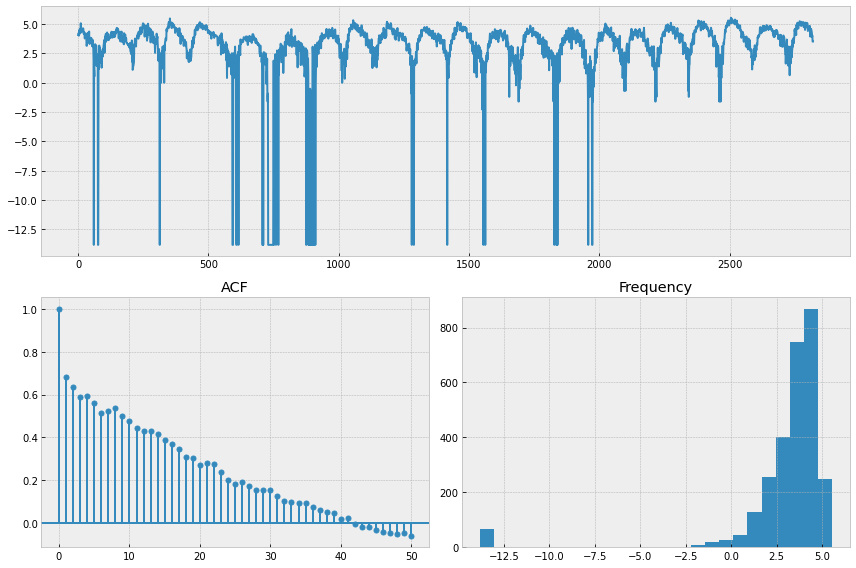

In [8]:
pm.tsdisplay(y_log, figsize=(12,8))

## Create exogenous date features

In [9]:
temp_data = pd.read_csv('../ts_data/daily-minimum-temperatures-in-me.csv', parse_dates=['Date'])
temp_data

,Date,Daily minimum temperatures
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8
...,...,...
3645,1990-12-27,14
3646,1990-12-28,13.6
3647,1990-12-29,13.5
3648,1990-12-30,15.7


In [10]:
temp_data.rename(columns={'Daily minimum temperatures':'temperature'}, inplace=True)
temp_data.temperature = temp_data.temperature.apply(lambda x: x.replace('?',''))
temp_data.temperature = temp_data.temperature.apply(np.float64)

In [11]:
temp_data.dtypes

Date           datetime64[ns]
temperature           float64
dtype: object

In [12]:
dfeat =  pm.preprocessing.DateFeaturizer(column_name='Date')
y, X_dfeat = dfeat.fit_transform(temp_data[['temperature']], temp_data[['Date']])

In [13]:
X_dfeat

,DATE-WEEKDAY-0,DATE-WEEKDAY-1,DATE-WEEKDAY-2,DATE-WEEKDAY-3,DATE-WEEKDAY-4,DATE-WEEKDAY-5,DATE-WEEKDAY-6,DATE-DAY-OF-MONTH
0,0,0,0,1,0,0,0,1
1,0,0,0,0,1,0,0,2
2,0,0,0,0,0,1,0,3
3,0,0,0,0,0,0,1,4
4,1,0,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...
3645,0,0,0,1,0,0,0,27
3646,0,0,0,0,1,0,0,28
3647,0,0,0,0,0,1,0,29
3648,0,0,0,0,0,0,1,30


## Fourier terms for modeling seasonality

In [14]:
electric_data = pd.read_csv('../ts_data/Electric_Production.csv', parse_dates=['DATE'], index_col=['DATE'])
electric_data 

,IPG2211A2N
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151
...,...
2017-09-01,98.6154
2017-10-01,93.6137
2017-11-01,97.3359


In [15]:
ff = pm.preprocessing.FourierFeaturizer(m=12, k=4)
y, X_ff = ff.fit_transform(electric_data)

In [16]:
X_ff

,FOURIER_S12-0,FOURIER_C12-0,FOURIER_S12-1,FOURIER_C12-1,FOURIER_S12-2,FOURIER_C12-2,FOURIER_S12-3,FOURIER_C12-3
0,0.500000,8.660254e-01,8.660254e-01,0.50000,1.000000e+00,-4.371139e-08,8.660254e-01,-0.50000
1,0.866025,5.000000e-01,8.660254e-01,-0.50000,-8.742278e-08,-1.000000e+00,-8.660255e-01,-0.50000
2,1.000000,-4.371139e-08,-8.742278e-08,-1.00000,-1.000000e+00,1.311342e-07,1.748456e-07,1.00000
3,0.866025,-5.000001e-01,-8.660255e-01,-0.50000,1.748456e-07,1.000000e+00,8.660253e-01,-0.50000
4,0.500000,-8.660254e-01,-8.660253e-01,0.50000,1.000000e+00,-2.185570e-07,-8.660255e-01,-0.50000
...,...,...,...,...,...,...,...,...
392,-1.000000,5.726192e-06,-1.145238e-05,-1.00000,1.000000e+00,-1.717858e-05,2.290477e-05,1.00000
393,-0.866023,5.000050e-01,-8.660311e-01,-0.49999,-1.722229e-05,-1.000000e+00,8.660139e-01,-0.50002
394,-0.499995,8.660283e-01,-8.660196e-01,0.50001,-1.000000e+00,1.726600e-05,-8.660369e-01,-0.49998
395,0.000006,1.000000e+00,1.153981e-05,1.00000,1.730971e-05,1.000000e+00,2.307961e-05,1.00000
